<a href="https://colab.research.google.com/github/rpizarrog/innovacion-empresarial/blob/main/notebook_python/Caso_02_Regresi%C3%B3n_Polinomial_con_datos_de_estaturas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objetivo

Construir e interpretar un modelo de regresión polinomial de segundo nivel, tercer nivel y quinto nivel.




# Descripción

* Cargar librerías.
* Crear funciones.
* Cargar datos.
* Crear modelo de regresión polinomial a la segunda potencia.
* Identificar métricas *r square* con valor por encima del  50 % para aceptar el modelo y de RMSE cercano a 0 que deberá ser comparado con otro modelo de regresión.
* Partir en datos de entrenamiento y datos de validación con el  70 % y  30 %.
* Evaluar modelo con datos de entrenamiento con el valor *r square*.
* Visualizar curva de regresión con el modelo construído y los datos de entrenamiento.
* Realizar predicciones utilizando el modelo con los datos de validación.
* Evaluar el modelo con el estadístico *RMSE root mean square error*
* Interpretar el caso.



# Desarrollo



## Cargar librerías


In [ ]:
import pandas as pd
import numpy as np
from sklearn import linear_model

from collections import Counter as Counter

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures # Polinomial
import math

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
#%matplotlib inline

## Crear funciones



In [ ]:
# Esta función regresa los datos en formato csv cargados en memoria RAM
def f_cargar_datos(ruta):
  # Cargar datos de la carpeta sample_data
  # datos = pd.read_csv('sample_data/estaturas_pesos.csv')

  # cargar datos de github.com enlace en la nube internet
  datos = pd.read_csv(ruta)
  return datos

# Función que devuelve las medias aritméticas y desviaciones estándar de dos variables numéricas de una muestra
def f_medias (independiente, dependiente):
  medias = [np.mean(independiente), np.mean(dependiente)]
  return medias

# Función que construye diagrama de dispersión
def f_dispersion (x, y, x_nombre, y_nombre):
  medias = f_medias(x, y)

  cova, r, r_square = f_cov_corr(x, y)   # Crear el diagrama de dispersión
  plt.scatter(x, y, s = 5)

  # Etiquetas y título
  plt.xlabel(x_nombre)
  plt.ylabel(y_nombre)
  plt.title(print('Diagrama de Dispersión. Corr Pearson'))

  plt.axvline(x=medias[0], color='blue', linestyle='--', linewidth=0.5,
            label="Media "+ x_nombre + ":" + str(np.round(medias[0], 2)))
  plt.axhline(y=medias[1], color='green', linestyle='--', linewidth=0.5,
            label="Media "+ y_nombre+":" + str(np.round(medias[1], 2)))
  plt.legend()

  # Subtítulo debajo del gráfico
  plt.figtext(0.5, -0.05, f'R Pearson: {np.round(r, 4)}', ha='center', fontsize=10)

  # Mostrar el diagrama de dispersión
  plt.show()

# Función que devuelve la covariana y correlación de Pearson y r square de dos variables numéricas de una muestra
def f_cov_corr(independiente, dependiente):
  covar = np.cov(independiente, dependiente, ddof=1)[0,1]
  r = np.corrcoef(independiente, dependiente)[0,1]
  r_square = r ** 2
  return covar, r, r_square

# Función que devuelve estad´siticos de una variable numérica
def f_media_moda_mediana_n(datos):
  # Calcular la media aritmética
  media = np.mean(datos)

  # Calcular la moda
  contador = Counter(datos)
  moda = contador.most_common(1)[0][0]

  # Calcular la mediana
  mediana = np.median(datos)

  # ¿Cuántos nnpúmeros son?
  n = len(datos)
  return media, moda, mediana, n

# función que visualiza histograma de una variable numérica en estructira tipo lista
# Re Utiliza la función f_media_moda_mediana_n
def f_histograma(datos, contexto):
  min = np.min(datos)
  max = np.max(datos)

# Convertir a entero
  min = int(min)
  max = int(max)

  # Calcular el número óptimo de clases usando la regla de Sturges
  n = len(datos)
  k = int(round(1 + math.log2(n)))

  plt.hist(datos, bins=range(min, max, k), edgecolor="black")
  plt.xlabel(contexto)

  media, moda, mediana, N = f_media_moda_mediana_n(datos)

  # Agregar líneas punteadas roja, azul y verde para representar media, mediana y moda
  medias = f_media_moda_mediana_n(datos)
  plt.axvline(x=media, color='red', linestyle='--', linewidth=2, label=f'Media: {media:.2f}')
  plt.axvline(x=mediana, color='blue', linestyle='--', linewidth=2, label=f'Mediana: {mediana:.2f}')
  plt.axvline(x=moda, color='yellow', linestyle='--', linewidth=2, label=f'Moda: {moda:.2f}')

  plt.ylabel("Frecuencia")
  plt.title("Distribución de los datos: "+contexto)

  plt.legend()
  plt.grid(False)
  plt.show()

def f_modelo_polinomial(v_independiente, v_dependiente, grado):
    """
    Ajusta un modelo de regresión polinomial.

    Parámetros:
    - v_independiente: array-like, variable independiente (X)
    - v_dependiente: array-like, variable dependiente (y)
    - grado: int, grado del polinomio

    Retorna:
    - modelo_polinomial: modelo de regresión ajustado
    - poly: objeto PolynomialFeatures para transformar nuevas entradas
    """
    # Transformar la variable independiente en características polinomiales
    poly = PolynomialFeatures(degree=grado)
    ind_train_poly = poly.fit_transform(v_independiente.reshape(-1, 1))

    # Construcción y entrenamiento del modelo de regresión lineal
    modelo_polinomial = LinearRegression()
    modelo_polinomial.fit(ind_train_poly, v_dependiente)  # Solo la Y original

    return modelo_polinomial, poly  # Devuelve también 'poly' para transformar futuras entradas


# Función que visualiza la dispersión de los datos y la curva de tendencia

def f_regresion_curva_tendencia(modelo, poly, x, y, xlabel, ylabel):
    """
    Grafica la curva de regresión polinomial y los datos originales.

    Parámetros:
    - modelo: modelo de regresión polinomial entrenado.
    - poly: objeto PolynomialFeatures utilizado para transformar los datos.
    - x: array-like, valores de la variable independiente.
    - y: array-like, valores de la variable dependiente.
    - xlabel: str, etiqueta del eje X.
    - ylabel: str, etiqueta del eje Y.
    """

    # Obtener el término de intercepción y coeficientes
    intercepto = modelo.intercept_
    coeficientes = modelo.coef_
    print(f"Intercepto (β0): {intercepto}")
    print(f"Coeficientes (β1, β2, ...): {coeficientes}")

    # Crear un rango de valores de X para visualizar la curva
    x_range = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)

    # Transformar los valores de X_range con el mismo objeto `poly`
    x_range_poly = poly.transform(x_range)

    # Predecir los valores de y para X_range
    predicciones = modelo.predict(x_range_poly)

    # Graficar los datos reales
    plt.scatter(x, y, color='blue', s=30, label='Datos originales')

    # Graficar la curva de regresión polinomial
    plt.plot(x_range, predicciones, color='red', label='Curva de tendencia')

    # Configurar etiquetas y título
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title('Regresión Polinomial')
    plt.legend()
    plt.grid()

    # Mostrar el gráfico
    plt.show()




## Cargar los datos


In [ ]:
# https://raw.githubusercontent.com/rpizarrog/innovacion-empresarial/refs/heads/main/datos/estaturas_pesos.csv
ruta = "https://raw.githubusercontent.com/rpizarrog/innovacion-empresarial/refs/heads/main/datos/estaturas_pesos.csv"
datos = f_cargar_datos(ruta)

print(datos)

## Mostrar la estructura de los datos

In [ ]:
datos.info()


## Análisis descriptivo

Se presentan los estadísticos mas importantes de las variables de interés con la función *describe()*

* Se define independiente = 'estaturas'
* Se define dependiente = 'pesos'

### Estadísticos

## Dispersión de los datos



In [ ]:
# estaturas pesos
independiente = 'estaturas'
dependiente = 'pesos'

datos[[independiente, dependiente]].describe()


## Histogramas


In [ ]:
f_histograma(datos[independiente], "Estatura")

f_histograma(datos[dependiente], "Pesos")

## Dispersión de los datos


In [ ]:
f_dispersion(datos[independiente], datos[dependiente], "estaturas", "pesos")


## Crear datos de entrenamiento y validación

* Los datos de entrenamiento serán aleatoriamente el 80% de los datos originales.
* Los datos de validación o prueba (test) serán aleatoriamente el complemento del 20%.
* Los datos de entrenamiento y datos de validación deben
ser mutuamente excluyentes que significa que están en uno conjunto o están en el otro.

Ahora que se tiene la variable independiente estaturas y la variable dependiente pesos, el siguiente paso es dividir estos datos en conjuntos de entrenamiento y prueba o validación.

Se utiiza el método *train_test_split()* que forma parte de la librería Scikit-Learn para dividir los datos en entrenamiento y validación.

El argumento *test_size* establece el 20% para datos de validación por lo que el $80$% pertenece a los datos de entrenamiento y el resto a datos de validación o prueba.

In [ ]:
# Convertir a numpy arrays
v_independiente = datos[independiente].to_numpy().reshape(-1, 1)  # Reshape para compatibilidad con sklearn
v_dependiente = datos[dependiente].to_numpy()

print (v_independiente)
print(v_dependiente)

In [ ]:


# División de los datos en entrenamiento (80%) y validación (20%)
ind_train, ind_test, dep_train, dep_test = train_test_split(
    v_independiente, v_dependiente, test_size=0.20, random_state=2025
)

# Crear DataFrame con datos de entrenamiento
datos_entrenamiento = pd.DataFrame({independiente: ind_train.flatten(), dependiente: dep_train})

# Crear DataFrame con datos de validación (corregido)
datos_validacion = pd.DataFrame({independiente: ind_test.flatten(), dependiente: dep_test})

# Mostrar los primeros valores de cada conjunto
print("\nDatos de entrenamiento:")
print(datos_entrenamiento)

print("\nDatos de validación:")
print(datos_validacion)


## r square con los datos de entrenamiento

In [ ]:
cova, r, r_square =  f_cov_corr(datos_entrenamiento[independiente], datos_entrenamiento[dependiente])
print ("Con los datos de entrenamiento; r square = ", r_square)

## Métricas de evaluación

El modelo se acepta si el valor de *r square* sobrepasa el  50 % tanto con los datos de entrenamiento como con los datos de validación.

El modelo a través de la métrica *root mean square error (RMSE)* que significa que tanto varía las predicciones con respecto a los datos reales se deberá comparar con otros modelos y los mismos datos para evalura su rendimiento.

## Construir el modelo polinomial de segundo nivel

### Preprocesamiento de los datos segundo nivel

Convertir las características de entrada en características polinomiales de segundo grado.


### Construir y entrenar el modelo de regresión polinomial segundo grado

Utilizar las características polinomiales para entrenar el modelo.




$$
predicciones = Y = \beta_0 + \beta_1\cdot x_i+\beta_2\cdot x_i^2 + … \beta_n \cdot x_i^n
$$

* $Y$ es la predicción.
* $β_0$ es el coeficiente de intersección de la abcisa.
* $β_1$ y $β_2$ son los coeficientes elevados a la primera y segunda potencia respectivamente.
* $x_i$ es el valor de $x_i$ es decir los valores de la variable independiente.



In [ ]:
# Ajuste del modelo polinomial de grado 2
grado = 2
modelo, poly = f_modelo_polinomial(ind_train, dep_train, grado=grado)

# Obtener los coeficientes del modelo
print("Coeficientes:", modelo.coef_)
print("Intercepto:", modelo.intercept_)




#### Curva de tendencia segundo nivel



In [ ]:
f_regresion_curva_tendencia(modelo, poly, ind_train, dep_train, xlabel=independiente, ylabel=dependiente)

#### Hacer predicciones con 170 segundo nivel

Usar el conjunto de validación para hacer predicciones y evaluar el rendimiento del modelo.

$$
\text{para x = 170 ¿Cual es la predicción aproximadamente?}
$$

$$
\text{predicción Y} =
213.4783 + (-2.6362\times x_i) + (0.0105 \times x_i^{2}
 )\approx
$$

$$
\text{predicción Y} =
213.4783 + (-2.6362\times 170) + (0.0105 \times 170^{2}
 )\approx
$$


In [ ]:
# 213.4783128008462 +(-2.63622128*170) + (0.01059294 * 170**2)
213.4783128008462 +(-2.63622128*170) + (0.01059294 * 170**2)

#### Predicciones segundo nivel

Se hacen predicciones con datos de validación

In [ ]:
# Las predicciones
# Transformar los datos de validación usando el mismo `poly` entrenado
ind_test_poly = poly.transform(ind_test)

# Realizar predicciones con el modelo polinomial
predicciones = modelo.predict(ind_test_poly)

# Mostrar las predicciones
print("\nPredicciones en los datos de validación:")
print(predicciones)




#### Comparaciones segundo nivel

Crear un data.frame llamado comparaciones a partir de la creación de un diccionario con los valores reales del conjunto de validacipon y las predicciones calculadas.

Con la función flatten().tolist() convierte el arreglo a una lista de una dimensión.

In [ ]:
diccionario = {'Estatura': ind_test.flatten().tolist(),
                'Real' : dep_test.flatten().tolist(),
               'Predicho' : predicciones.flatten().tolist() }
# diccionario

comparaciones = pd.DataFrame(diccionario)
print (comparaciones)

#### RMSE segundo nivel

¿Qué tanto se desvián las predicciones de los valores reales?

Error estándar médio MSE
$$
MSE = \frac{\sum(predicho_i - real_i)^{2}}{n}
$$

Raiz del error estándar medio

$$
RMSE = \sqrt{\frac{\sum(predicho_i - real_i)^{2}}{n}}
$$

In [ ]:
print('Mean Absolute Error: MAE', metrics.mean_absolute_error(dep_test, predicciones))
print('Mean Squared Error: MSE', metrics.mean_squared_error(dep_test, predicciones))
print('Root Mean Squared Error RMSE:', np.sqrt(metrics.mean_squared_error(dep_test, predicciones)))

cova, r, r_square =  f_cov_corr(ind_test.flatten(), dep_test.flatten())
print ("r square = ", r_square)



### Construir y entrenar el modelo de regresión polinomial tercer grado


In [ ]:
# Ajuste del modelo polinomial de grado 3
grado = 3
modelo, poly = f_modelo_polinomial(ind_train, dep_train, grado=grado)

# Obtener los coeficientes del modelo
print("Coeficientes:", modelo.coef_)
print("Intercepto:", modelo.intercept_)

#### Curva de tendencia tercer grado


In [ ]:
f_regresion_curva_tendencia(modelo, poly, ind_train, dep_train, xlabel=independiente, ylabel=dependiente)

#### Predicciones tercer grado

Se hacen predicciones con datos de validación

In [ ]:
# Las predicciones
# Transformar los datos de validación usando el mismo `poly` entrenado
ind_test_poly = poly.transform(ind_test)

# Realizar predicciones con el modelo polinomial
predicciones = modelo.predict(ind_test_poly)

# Mostrar las predicciones
print("\nPredicciones en los datos de validación:")
print(predicciones)

In [ ]:
diccionario = {'Estatura': ind_test.flatten().tolist(),
                'Real' : dep_test.flatten().tolist(),
               'Predicho' : predicciones.flatten().tolist() }
# diccionario

comparaciones = pd.DataFrame(diccionario)
print (comparaciones)

#### RMSE tercer grado


In [ ]:
print('Mean Absolute Error: MAE', metrics.mean_absolute_error(dep_test, predicciones))
print('Mean Squared Error: MSE', metrics.mean_squared_error(dep_test, predicciones))
print('Root Mean Squared Error RMSE:', np.sqrt(metrics.mean_squared_error(dep_test, predicciones)))

cova, r, r_square =  f_cov_corr(ind_test.flatten(), dep_test.flatten())
print ("r square = ", r_square)

### Construir y entrenar el modelo de regresión polinomial cuarto grado

pendiente


In [ ]:
# Ajuste del modelo polinomial de grado 3
grado = 4
modelo, poly = f_modelo_polinomial(ind_train, dep_train, grado=grado)

# Obtener los coeficientes del modelo
print("Coeficientes:", modelo.coef_)
print("Intercepto:", modelo.intercept_)

In [ ]:
f_regresion_curva_tendencia(modelo, poly, ind_train, dep_train, xlabel=independiente, ylabel=dependiente)

In [ ]:
# Las predicciones
# Transformar los datos de validación usando el mismo `poly` entrenado
ind_test_poly = poly.transform(ind_test)

# Realizar predicciones con el modelo polinomial
predicciones = modelo.predict(ind_test_poly)

# Mostrar las predicciones
print("\nPredicciones en los datos de validación:")
print(predicciones)

In [ ]:
diccionario = {'Estatura': ind_test.flatten().tolist(),
                'Real' : dep_test.flatten().tolist(),
               'Predicho' : predicciones.flatten().tolist() }
# diccionario

comparaciones = pd.DataFrame(diccionario)
print (comparaciones)

In [ ]:
print('Mean Absolute Error: MAE', metrics.mean_absolute_error(dep_test, predicciones))
print('Mean Squared Error: MSE', metrics.mean_squared_error(dep_test, predicciones))
print('Root Mean Squared Error RMSE:', np.sqrt(metrics.mean_squared_error(dep_test, predicciones)))

cova, r, r_square =  f_cov_corr(ind_test.flatten(), dep_test.flatten())
print ("r square = ", r_square)

### Construir y entrenar el modelo de regresión polinomial quinto grado

peendiente

In [58]:
# Ajuste del modelo polinomial de grado 3
grado = 5
modelo, poly = f_modelo_polinomial(ind_train, dep_train, grado=grado)

# Obtener los coeficientes del modelo
print("Coeficientes:", modelo.coef_)
print("Intercepto:", modelo.intercept_)

Coeficientes: [ 0.00000000e+00 -4.17252514e-02 -3.55171998e+00  4.22736378e-02
 -1.88146297e-04  2.97137246e-07]
Intercepto: 9986.272164522676


Intercepto (β0): 9986.272164522676
Coeficientes (β1, β2, ...): [ 0.00000000e+00 -4.17252514e-02 -3.55171998e+00  4.22736378e-02
 -1.88146297e-04  2.97137246e-07]


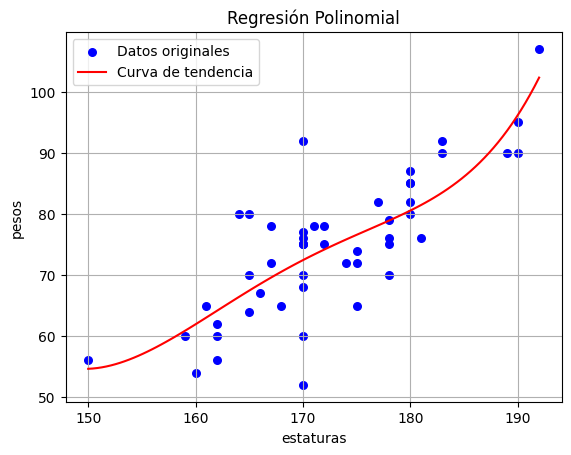

In [59]:
f_regresion_curva_tendencia(modelo, poly, ind_train, dep_train, xlabel=independiente, ylabel=dependiente)

In [60]:
# Las predicciones
# Transformar los datos de validación usando el mismo `poly` entrenado
ind_test_poly = poly.transform(ind_test)

# Realizar predicciones con el modelo polinomial
predicciones = modelo.predict(ind_test_poly)

# Mostrar las predicciones
print("\nPredicciones en los datos de validación:")
print(predicciones)


Predicciones en los datos de validación:
[89.34885854 57.02494474 76.56740573 67.44528664 72.42557441 74.16846204
 67.44528664 65.25572228 61.92672343 61.92672343 80.53690502 86.07792861
 76.56740573]


In [ ]:
diccionario = {'Estatura': ind_test.flatten().tolist(),
                'Real' : dep_test.flatten().tolist(),
               'Predicho' : predicciones.flatten().tolist() }
# diccionario

comparaciones = pd.DataFrame(diccionario)
print (comparaciones)

In [61]:
print('Mean Absolute Error: MAE', metrics.mean_absolute_error(dep_test, predicciones))
print('Mean Squared Error: MSE', metrics.mean_squared_error(dep_test, predicciones))
print('Root Mean Squared Error RMSE:', np.sqrt(metrics.mean_squared_error(dep_test, predicciones)))

cova, r, r_square =  f_cov_corr(ind_test.flatten(), dep_test.flatten())
print ("r square = ", r_square)

Mean Absolute Error: MAE 5.289350563727567
Mean Squared Error: MSE 66.84360754556671
Root Mean Squared Error RMSE: 8.175794000925336
r square =  0.5115185155855867





# Interpretación

Se cargó un conjunto de datos con variables de interés estaturas y pesos corporales de personas.

Se construyó un modelo de regresión polinómica a segundo nivel con datos de entrenamiento. La variable estaturas fué la variable predictora o independiente y la variable peso fue la variable objetivo o dependiente.

A partir el modelo de regresión polinómica se extrajeron los coeficientes de la abcisa o intersección y los coeficientes.

Coeficiene intersección:  223.01097115218664
Coeficientes de acuerdo a la  segunda potencia
[ 0.         -2.63613353  0.01027113]

Estos valores significan los valores para la estimación de la curva de acuerdo al modelo.

Se visualizó la dispersión de los datos con los valores de entrenamiento y se estimó la curva de regresión presentada también visualmente.

Habiendo relizado una evaluación del modelo con datos de entrenamiento o datos que se utilizaron para construir el modelo con el estadístico *r square* o coeficiente de determinación se encontró que el valor de estaturas representa aproximadamente un  62  % al valor del peso corporal de una persona.

Se utilizaron datos de prueba o datos de validación con las mismas variables de estaturas y pesos para construir predicciones.

Habiendo relizado una evaluación del modelo con los datos de validación o datos de prueba con el estadístico *r square* o coeficiente de determinación se encontró que el valor de estatura representa aproximadamente un 51 % al valor del peso corporal de una persona.

El modelo se acepta datos que el valor de *r square* como métrica establecida inicialmente sobrepasa el 50 % tanto con los datos de entrenamiento como con los datos de validación.

El valor de *RMSE root mean square error* o error cuadrático medio significa que tanto el modelo es eficiente y su valor cercano a cero representa esa eficiencia.

El valor del modelo polinomial segundo nivel fue de fue de  7.48  aproximadamente y debe ser comparado contra otro modelo para medir su eficiencia en relación con otros.

El valor del modelo polinomial tercer grado de fue de  7.72 aproximadamente y debe ser comparado contra otro modelo para medir su eficiencia en relación con otros.

Comparado contra el modelo de regresión linel simple es mejor el modelo polinómico de segundo nivel ya que RMSE es menor.

Evaluación de modelos de regresión en datos bivariados

* Se identifican los estadísticos que permiten evaluar el rendimiento de modelos de regresión que realizan predicciones de pesos de personas como variable dependiente y estaturas como variable independiente.
* Se analizaron 62 observaciones, dos variables estaturas y pesos.
* Se hizo una partición de datos de entrenamiento 80% y 20% para datos de validación con una semilla de 2025 para la selección aleatoria de los datos.
* Se hizo la evaluación usando programación Python.

Los resultados se muestran en la Tabla

Para cada modelo se calcula *R Square con datos de entrenamiento*; 	*R Square con datos de validación* y el estadístico *RMSE*

* Regresión Lineal Simple	62%	51%	8.0441
* Polinomial Segundo Grado	62%	51%	7.4886
* **Polinomial Tercer Grado	62%	51%	7.7232**
* Polinomial Cuarto Grado	62%	51%	8.2320
* Polinomial Quinto Grado	62%	51%	8.1757


El modelo mas eficiente para estos datos y de acuerdo al valor RMSE fue el de algoritmo **Polinomial de Tercer Grado.**


!Hasta la próxima!